In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

def gaussianKernel3Dcalculation(patchWindowRadius, sigma):
    # Calculate the patch window size from the given patch window radius
    patchWindowSize = 2 * patchWindowRadius + 1
    # Initialize the kernel sum and final kernel array to zeros
    kernelSum = 0
    kernel = np.zeros(patchWindowSize * patchWindowSize * patchWindowSize)
    # Calculate the kernel elements by looping through in all dimensions
    for z in range(-patchWindowRadius, patchWindowRadius + 1):
        for y in range(-patchWindowRadius, patchWindowRadius + 1):
            for x in range(-patchWindowRadius, patchWindowRadius + 1):
                # Getting the kernel output index
                kernelIndex = (z + patchWindowRadius) * patchWindowSize * patchWindowSize + (
                                y + patchWindowRadius) * patchWindowSize + (x + patchWindowRadius)
                # Calculating the kernel value
                kernel[kernelIndex] = np.exp(-(z * z + y * y + x * x) / (2 * sigma * sigma))
                # Adding the calculating kernel value to the kernel sum
                kernelSum += kernel[kernelIndex]
    for index in range(patchWindowSize * patchWindowSize * patchWindowSize):
        # Normalizing the calculated kernel values
        kernel[index] /= kernelSum
    return kernel

def nonLocalMeansSerial(inputDataWithNoise, kernel, imageWidth, imageHeight, slicesCount, searchWindowRadius,
                        patchWindowRadius, stdDev):
    outputDenoisedData = np.zeros(imageWidth * imageHeight * slicesCount)
    # Go over the entire voxels in the image
    for z in range(patchWindowRadius, slicesCount + patchWindowRadius):
        for y in range(patchWindowRadius, imageHeight + patchWindowRadius):
            for x in range(patchWindowRadius, imageWidth + patchWindowRadius):
                # Initialize all voxels of the output data to zeros
                outputDenoisedData[(z - patchWindowRadius) * imageHeight * imageWidth + (y - patchWindowRadius) *
                                   imageWidth + (x - patchWindowRadius)] = 0
                # Initialize the sum of weights and max weight to zero
                sumWeights = 0
                maxWeight = 0
                # Calculate start and end points for search window in all three dimensions
                startSearchZ = max(z - searchWindowRadius, patchWindowRadius)
                endSearchZ = min(z + searchWindowRadius, slicesCount + patchWindowRadius - 1) + 1
                startSearchY = max(y - searchWindowRadius, patchWindowRadius)
                endSearchY = min(y + searchWindowRadius, imageHeight + patchWindowRadius - 1) + 1
                startSearchX = max(x - searchWindowRadius, patchWindowRadius)
                endSearchX = min(x + searchWindowRadius, imageWidth + patchWindowRadius - 1) + 1
                # Run over the search window of the voxel
                for searchPosZ in range(startSearchZ, endSearchZ):
                    for searchPosY in range(startSearchY, endSearchY):
                        for searchPosX in range(startSearchX, endSearchX):
                            # If the search window position has reached the boundary in all 3 dimensions then don't consider this window
                            if searchPosX == x and searchPosY == y and searchPosZ == z:
                                continue

                            # Initialize the distance and weight metrics to zero
                            distance = 0
                            weight = 0

                            # Run over the patch window of the voxel
                            for patchPosZ in range(-patchWindowRadius, patchWindowRadius + 1):
                                for patchPosY in range(-patchWindowRadius, patchWindowRadius + 1):
                                    for patchPosX in range(-patchWindowRadius, patchWindowRadius + 1):
                                        # Get the indexes for search window
                                        searchPosIndex = (searchPosZ + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius) + \
                                                         (searchPosY + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (searchPosX + patchPosX)
                                        # Get the index for kernel
                                        kernelPosIndex = (patchPosZ + patchWindowRadius) * (2 * patchWindowRadius + 1) * (2 * patchWindowRadius + 1) + \
                                                         (patchPosY + patchWindowRadius) * (2 * patchWindowRadius + 1) + (patchPosX + patchWindowRadius)
                                        # Get the index for the voxel
                                        voxelPosIndex = (z + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius) + \
                                                        (y + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (x + patchPosX)
                                        # Compute the gaussian kernel weighted euclidean distance
                                        distance += kernel[kernelPosIndex] * (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex]) * \
                                                    (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex])

                            # Compute the weight for search window voxel
                            weight = np.exp(-distance / (stdDev * stdDev))
                            # Adding up weights for all voxels in search window
                            sumWeights += weight
                            # Getting the maximum weight within the search window
                            maxWeight = max(maxWeight, weight)
                            # Writing to the output voxel
                            outputDenoisedData[(z - patchWindowRadius) * imageHeight * imageWidth + (y - patchWindowRadius) * imageWidth +
                                               (x - patchWindowRadius)] += weight * inputDataWithNoise[searchPosZ * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius) +
                                                                                                       searchPosY * (imageWidth + 2 * patchWindowRadius) + searchPosX]
                # Writing to the output voxel
                outputDenoisedData[(z - patchWindowRadius) * imageHeight * imageWidth + (y - patchWindowRadius) *
                                   imageWidth + (x - patchWindowRadius)] += maxWeight * \
                                    inputDataWithNoise[z * (imageHeight + 2 * patchWindowRadius) *
                                    (imageWidth + 2 * patchWindowRadius) + y * (imageWidth + 2 * patchWindowRadius) + x]
                # Normalizing the denoised output
                outputDenoisedData[(z - patchWindowRadius) * imageHeight * imageWidth +
                                   (y - patchWindowRadius) * imageWidth + (x - patchWindowRadius)] /= (sumWeights + maxWeight)
    return outputDenoisedData

if __name__ == "__main__":
    # Patch Window size taken as 5X5X5
    patchWindowRadius = 2
    # Search Window size taken as 11X11X11
    searchWindowRadius = 5
    # Dimensions of the test image
    imageWidth = 181
    imageHeight = 217
    slicesCount = 2
    # Default values of sigma and standard values defined
    sigma = 1
    stdDev = 10.0
    # Reading input binary data as a float 32 array
    inputDataWithNoise = np.fromfile("imageNoisyPaddedInput5X5X5Slices2.bin", dtype = np.float32, sep = '')
    # Computing the gaussian filter kernel
    kernel = gaussianKernel3Dcalculation(patchWindowRadius, sigma)
    # Starting the time measurement
    start = time.time()
    # Calling the python denoising algorithm
    outputDenoisedData = nonLocalMeansSerial(inputDataWithNoise, kernel, imageWidth, imageHeight, slicesCount, searchWindowRadius, patchWindowRadius, stdDev)
    # Recording the time taken for image denoising using python
    time_ = (time.time() - start)
    print("Time taken to denoise by python program is ", time_)
    # Write the python denoised output float 32 array to a binary file
    outputDenoisedData.astype('float32').tofile('python_output.bin', sep = '')

Time taken to denoise by python program is  6243.195792198181


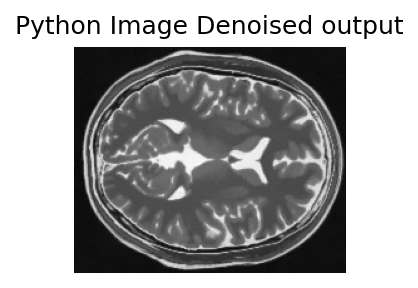

In [2]:
# Serial implementation denoised image
# Reshaping the numpy float 1D array to 3D images dimensions
denoise = outputDenoisedData.reshape(slicesCount, imageHeight, imageWidth).T
fig = plt.figure(figsize = (3, 2), dpi = 150)
plt.axis('off')
plt.title('Python Image Denoised output')
plt.imshow(denoise[:, :, 1], cmap='gray')
plt.savefig('pythonImageDenoised.png')